# Mach Stem Height

In [3]:
import numpy as np
from scipy import optimize
import intersection 
import matplotlib.pyplot as plt

def phi(theta, M):
    out = optimize.fsolve(lambda x: fun(x,M,theta),0.01)
    out = np.append(out, optimize.fsolve(lambda x: fun(x,M,theta),np.pi/2))
    return out
def theta(x,M):
    out = 2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2)
    out = np.arctan(out)
    return out
def fun(x,M,theta):
    f=np.tan(theta)-2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2)
    return f
def fun2(x,M):
    theta=np.arctan(2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2))
    return theta
def thetaMax(M):
    phi=optimize.fmin(lambda x: -fun2(x,M),0.1)
    theta=fun2(phi,M)
    return theta

class state(object):
  def __init__(self,p=100000,M=1.5,T=300,R=287,phi=0,gamma=1.4):
    self.p=p
    self.M=M
    self.T=T
    self.gamma=gamma
    self.phi=phi
    self.R=R
    self.rho=self.p/(self.R*self.T)
    self.u=self.M*np.sqrt(self.gamma*self.R*self.T)
    
def oblique(state0,theta1=10*np.pi/180,weak='True'):
  p=phi(theta1,state0.M)
  tmax=thetaMax(state0.M)
  print("Theta max :",tmax*180/np.pi)
  if tmax<theta1:
        print("Shock detached")
  else:
    if weak=='True':
      ph=p[0]
    else:
      ph=p[1]
    M1=np.sqrt((1+(state0.gamma-1)*0.5*(state0.M*np.sin(ph))**2)/(state0.gamma*(state0.M*np.sin(ph))**2-(state0.gamma-1)*0.5))/(np.sin(ph-theta1))
    p2=state0.p*(1+2*state0.gamma*((state0.M*np.sin(ph))**2-1)/(1+state0.gamma))
    T2=state0.T*(p2/state0.p)*(2+(state0.gamma-1)*(state0.M*np.sin(ph))**2)/((1+state0.gamma)*(state0.M*np.sin(ph))**2)
    state1=state(M=M1,p=p2,T=T2)
    state1.phi = ph
    state1.theta= theta1
    return state1

def ST(state0,theta1):
    state1=oblique(state0,theta1=theta1)
    print("Max shock angle for RR:",phi(thetaMax(state1.M),state1.M)*180/np.pi)
    if 0: #theta1<thetaMax(state1.M):
        print("This case is a Regular reflection")
        print("Solving using 2 shock theory . . .")
        state2=oblique(state1,theta1=theta1)
        return state1,state2
    else:
        print("This case is a Mach reflection")
        print("Solving for the Standard solution using 3 shock theory...")
        phid = ThreeST1(state0,state1,theta1)
        print("Output : ", phid*180/np.pi)
        phi2 = phid[0]
        phi3 = phid[1]
        #print("--------------------------------------")
        #print("Post opti phi2 :", phi2*180/np.pi )
        #print("Post opti phi3 :", phi3*180/np.pi )
        #print("--------------------------------------")
        #theta2 = (theta(phi2,state1.M))
        theta2 = phid[2]
        print(theta2*180/np.pi)
        #theta3 = theta(phi3,state0.M)
        theta3 =phid[3]
        state3 = oblique(state0,theta1=theta3,weak='False')
        state3.phi = phi3
        state3.theta = theta3
        state2 = oblique(state1,theta1=theta2)
        state2.phi = phi2
        state2.theta =theta2
        """
        print("-----------------------")
        print("M1", state1.M)
        print("M2", state2.M)
        print("M3", state3.M)
        print("phi1", state1.phi*180/np.pi)
        print("phi2", state2.phi*180/np.pi)
        print("phi3",state3.phi*180/np.pi)
        print("theta1", state1.theta*180/np.pi)
        print("theta2", state2.theta*180/np.pi)
        print("theta3",state3.theta*180/np.pi)
        print("-----------------------")
        """
        return state1,state2,state3

def ThreeST(state0,state1,theta):
    p = np.zeros(4)
    p[0] = state0.M  # M0
    p[1] = state1.M  # M1
    p[2] = theta  # theta
    p[3] = state1.p/state0.p # p1/p0
    #p1 = [state0.M,state1.M,theta]
    #bounds = [(0, np.pi/2), (0,  np.pi/2)]
    #sol = optimize.differential_evolution(lambda x: fun3(x,p), bounds)
    #print(sol.x)
    #return sol.x
    return optimize.fmin(lambda x: fun3(x,p),1*np.array([0.01,0.01]))
    
def fun3(x,p,gamma = 1.4):
    """
    x[0] - phi2
    x[1] - phi3
    """
    f=np.array([])
    f=np.append(f,1000*((1+2*(p[1]**2*np.sin(x[0])**2-1)*gamma/(gamma+1))*p[3]-(1+2*(p[0]**2*np.sin(x[1])**2-1)*gamma/(gamma+1))))
    f=np.append(f,(p[2]-theta(x[0],p[1])-theta(x[1],p[0]))*180/np.pi)
    out = f[0]*10+f[1]*1000
    #return f
    return out
    
    
def polar(M0,both = 'True',type ='p', positive='True',gamma=1.4):
    tmax = thetaMax(M0)
    print("ThetaMax:", tmax*180/np.pi)
    theta = np.linspace(0,tmax,100)
    if type == 'p':
      pWeak = np.asarray([pRatio(k,M0) for k in theta])
      pStrong = np.asarray([pRatio(k,M0,weak = 'False') for k in theta])
    elif type == 'M':
      pWeak = np.asarray([Mj(k,M0) for k in theta])
      pStrong = np.asarray([Mj(k,M0,weak = 'False') for k in theta])
    elif type == 'rho':
      pWeak = np.asarray([rho(k,M0) for k in theta])
      pStrong = np.asarray([rho(k,M0,weak = 'False') for k in theta])
    elif type == 'T':
      pWeak = np.asarray([pRatio(k,M0)/rho(k,M0) for k in theta])
      pStrong = np.asarray([pRatio(k,M0,weak = 'False')/rho(k,M0,weak = 'False') for k in theta])  
    theta = np.append(theta,np.flipud(theta))
    p = np.append(pWeak,np.flipud(pStrong))
    if both =='True':
       p = np.append(p,np.flipud(p))
       theta = np.append(theta,np.flipud(-theta))
    return theta, p


def plot(theta,p,label):
    for k,j,m in zip(theta,p,label):
        plt.plot(theta[k]*180/np.pi,p[j],label=label[m])
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel('theta')
    plt.savefig("DiamondFoil.eps", format='eps', dpi=1000)
    plt.show()
  
   
def Mj(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    Mj=np.sqrt((1+(gamma-1)*0.5*(M*np.sin(z))**2)/(gamma*(M*np.sin(z))**2-(gamma-1)*0.5))/(np.sin(z-x))
    return Mj

def rho(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    rho=((1+gamma)*(M*np.sin(z))**2)/(2+(gamma-1)*(M*np.sin(z))**2)
    return rho    
    
def pRatio(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    p = 1+2*gamma*((M*np.sin(z))**2-1)/(1+gamma)
    return p

def pRatio1(z,M,gamma =1.4, weak = 'True'):
    p = 1+2*gamma*((M*np.sin(z))**2-1)/(1+gamma)
    return p
def pRatioMax(M):
    return optimize.fmin(lambda x: -pRatio(x,M,gamma=1.4),0.1)

def nu(M,gamma=1.4):
    return np.sqrt((gamma+1)/(gamma-1))*np.arctan(np.sqrt((gamma-1)*(M**2-1)/(gamma+1)))-np.arctan(np.sqrt(M**2-1))

"""
def Mprandtl(nu0,gamma=1.4):
    return optimize.fmin(lambda x: nu0-nu(x),0.01)
"""

def Mpr(nu):
    """
    obtained using Hall's approximation
    """
    nu0 = np.pi*0.5*(np.sqrt(6)-1)
    A = 1.3604
    B = 0.0962
    C = -0.5127
    D = -0.6722
    E = -0.3278
    y = (nu/nu0)**(2/3)
    return (1+A*y+B*y**2+C*y**3)/(1+D*y+E*y**2)

def pRatioIsen(M1,M2,gamma=1.4):
    return ((1+(gamma-1)*0.5*M1**2)/(1+(gamma-1)*0.5*M2**2))**(gamma/(gamma-1))

def polarIsen(M1, thetamax = 0,  gamma=1.4):
    nu1 = nu(M1)
    nu2max =  np.pi*0.5*(np.sqrt((gamma+1)/(gamma-1))-1)
    if thetamax == 0 :
        thetamax = nu2max-nu1
    theta = np.linspace(0,thetamax,100)    
    M2 = M(theta+nu1)
    p = pRatioIsen(M1, M2,gamma=gamma)
    theta = np.append(theta,np.flipud(theta))
    theta = np.append(theta,np.flipud(-theta))
    p = np.append(p,np.flipud(p))
    p = np.append(p,np.flipud(p))
    return theta,p

def Mprandtl(theta,M0):
    nu0=nu(M0)
    M1 = M(theta+nu0)
    return M1
    
def Mshock(z,M,gamma =1.4, weak = 'True'):
    x = theta(z,M)
    Mj=np.sqrt((1+(gamma-1)*0.5*(M*np.sin(z))**2)/(gamma*(M*np.sin(z))**2-(gamma-1)*0.5))/(np.sin(z-x))
    return Mj

In [82]:
def ThreeST1(state0,state1,theta1):
    M0 = state0.M
    t1 =theta1
    M1u=state1.M
    theta1, p1 = polar(M0)
    theta2u, p2u = polar(M1u)
    p1u_= np.interp(t1,theta1[:100],p1[:100])
    y1= p2u*p1u_
    theta={1:theta1[:200],       2:theta2u[-200:]+t1} 
    p    ={1:p1[:200],       2: y1[-200:]}
    label = {1: 'incident',         2: 'r - upper'}
    plot(theta,p,label)
    x,y=intersection.intersection(theta1,p1,theta2u[-200:]+t1, y1[-200:])
    #print("Solutions:")
    #print(x[0]*180/np.pi, "degrees :", y[0])
    #print(np.min(x)*180/np.pi, "degrees :", y[-1])
    theta3 = np.min(x)
    out1 = phi(theta3,M0)
    out2 = phi(theta1-theta3,M1u)
    out = np.array([out2[0],out1[1]])
    out = np.append(out,t1-theta3)
    out = np.append(out,theta3)
    return out

In [5]:
def azevedo(M0=2.5,phi1 = 38.5,gp=1.2,gamma=1.4):
    t1 = theta(phi1*np.pi/180,M0) 
    s0=state(M=M0,p=1, T = 300)
    s1,s2,s3=ST(s0,theta1=t1)
    print("Turn angle :", t1*180/np.pi)
    pref = s0.rho*(s0.u)**2
    B = np.array([gp+np.sin(s1.theta)])
    B = np.append(B, gp+np.sin(s1.theta)-s1.p*np.sin(s1.theta)/pref+(gp+np.sin(s1.theta))/gamma/M0**2)
    B = np.append(B, -np.cos(s1.theta)/gamma/M0**2+s1.p*np.cos(s1.theta)/pref)
    B = np.append(B,0)
    B = np.append(B,gp)
    A = np.zeros([5,5])
    Ma = Mshock(np.pi/2,M0,gamma = gamma, weak = 'True')
    print("Ma :", Ma)
    Ar = ((1+(gamma-1)*0.5*Ma**2)*2/(gamma+1))**((gamma+1)/(2*(gamma-1)))*(1/Ma)
    print("Area ratio :", Ar)
    phi = s2.phi-s1.theta
    delta = s1.theta-s2.theta
    Pa = pRatio1(np.pi/2,M0,gamma =1.4, weak = 'False')
    #Pa = pRatioMax(M0)
    print("Pa :", Pa)
    Pstar = Pa*((1+(gamma-1)*0.5*Ma**2)*2/(gamma+1))**(gamma/(gamma-1))
    ###
    A[0,2] = Ar
    A[0,3] = np.sin(s1.phi)/(np.sin(s1.phi-s1.theta)*s1.M)
    A[0,4] = np.sin(s1.phi)*np.sin(phi+s1.theta)/(s2.M*np.sin(s1.phi-s1.theta)*np.sin(phi+delta))
    ###
    ##
    A[1,2] = (gamma+1)*Pstar/pref
    A[1,3] = (gamma*s1.p*s1.M*np.cos(s1.theta)+s1.p*np.sin(s1.theta+np.arcsin(1/s1.M)))/pref
    A[1,4] = (gamma*s2.p*s2.M*np.cos(delta)+s2.p*np.sin(delta+np.arcsin(1/s2.M)))/pref
    ###
    A[2,0] = 1/gamma/M0**2
    A[2,1] = s3.p/pref
    A[2,3] = (gamma*s1.p*s1.M*np.sin(s1.theta)-s1.p*np.cos(s1.theta+np.arcsin(1/s1.M)))/pref
    A[2,4] = (gamma*s2.p*s2.M*np.sin(delta)-s2.p*np.cos(delta+np.arcsin(1/s2.M)))/pref
    ##
    A[3,0] = 1
    A[3,1] = 1
    A[3,3] = -np.cos(np.arcsin(1/s1.M)+s1.theta) 
    A[3,4] = -np.cos(np.arcsin(1/s2.M)+delta) 
    A[4,2] = 1
    A[4,3] = np.sin(np.arcsin(1/s1.M)+s1.theta)
    A[4,4] = np.sin(np.arcsin(1/s2.M)+delta)
    x = np.linalg.solve(A,B)
    print(A)
    print(x)
    s1 = Ar*x[2]
    A1 = np.array([[Ar, A[0,3],A[0,4]],[A[1,2],A[1,3],A[1,4]],[1,A[4,3],A[4,4]]])
    B1= B[2:]
    x = np.linalg.solve(A1,B1)
    print(x)
    s2 = Ar*x[0]
    #s2 = x[2]+x[1]*np.tan(delta)
    #s3 = gp + np.sin(s1.theta)-(x[0]+np.cos(s1.theta))*np.tan(s1.phi)
    return s1,s2


def mounton(M=2.5,phi1 = 38.5,gp=1.2,gamma=1.4):
    t1 = theta(phi1*np.pi/180,M) 
    s0=state(M=M,p=1, T = 300)
    s1,s2,s3=ST(s0,theta1=t1)
    #print("Turn angle :", t1*180/np.pi)
    B = np.array([gp+np.sin(s1.theta)])
    B = np.append(B, gp)
    B = np.append(B, -np.cos(s1.theta))
    B = np.append(B, -np.cos(s1.theta))
    B = np.append(B, -np.sin(s1.theta))
    A = np.zeros([5,5])
    Ma = Mshock(np.pi/2,M,gamma = gamma, weak = 'True')
    Ar = ((1+(gamma-1)*0.5*Ma**2)*2/(gamma+1))**((gamma+1)/(2*(gamma-1)))*(1/Ma)
    #print("Area ratio :", Ar)
    phi = s2.phi-s1.theta
    delta = s1.theta-s2.theta
    A[0,0] = np.sin(s1.phi)
    A[0,1] = Ar
    A[1,1] = 1
    A[1,2] = np.sin(delta+np.arcsin(1/s2.M))
    A[1,3] = np.sin(s1.theta+np.arcsin(1/s1.M))
    A[2,0] = -np.cos(s1.phi)
    A[2,1] = -(Ar-1)/np.tan(delta)
    A[2,2] = np.cos(delta+np.arcsin(1/s2.M))
    A[2,3] = np.cos(s1.theta+np.arcsin(1/s1.M))
    A[3,0] = -np.cos(s1.phi)
    A[3,3] = np.cos(s1.theta+np.arcsin(1/s1.M))
    A[3,4] = -np.cos(phi)
    A[4,0] = -np.sin(s1.phi)
    #A[4,2] = 1
    A[4,3] = np.sin(s1.theta+np.arcsin(1/s1.M))
    A[4,4] = np.sin(phi)    
    #print(A)
    x = np.linalg.solve(A,B)
    s = Ar*x[1]
    #print(x)
    return s


In [6]:
mounton(M=3.98,phi1 =34,gp=0.4)

Optimization terminated successfully.
         Current function value: -0.675615
         Iterations: 20
         Function evaluations: 40
Theta max : [38.70987144]
Optimization terminated successfully.
         Current function value: -0.513914
         Iterations: 20
         Function evaluations: 40
Max shock angle for RR: [64.75650448 64.75765955]
This case is a Mach reflection
Solving for the Standard solution using 3 shock theory...
Optimization terminated successfully.
         Current function value: -0.675615
         Iterations: 20
         Function evaluations: 40
ThetaMax: [38.70987144]
Optimization terminated successfully.
         Current function value: -0.513914
         Iterations: 20
         Function evaluations: 40
ThetaMax: [29.44511721]
Output :  [23.36954193 89.78656269 20.51083696  0.75984868]
20.510836957641487
Optimization terminated successfully.
         Current function value: -0.675615
         Iterations: 20
         Function evaluations: 40
Theta max : [

0.008417259096653753

Optimization terminated successfully.
         Current function value: -0.574313
         Iterations: 20
         Function evaluations: 40
Theta max : [32.90570853]
Optimization terminated successfully.
         Current function value: -0.378402
         Iterations: 20
         Function evaluations: 40
Max shock angle for RR: [64.74272746 64.74423085]
This case is a Mach reflection
Solving for the Standard solution using 3 shock theory...
Optimization terminated successfully.
         Current function value: -0.574313
         Iterations: 20
         Function evaluations: 40
ThetaMax: [32.90570853]
Optimization terminated successfully.

C:\Users\sagar\Jupyter Notebooks\Academics\Shockwave Dynamics\intersection.py:86: RuntimeWarning: invalid value encountered in greater_equal
  in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)
C:\Users\sagar\Jupyter Notebooks\Academics\Shockwave Dynamics\intersection.py:86: RuntimeWarning: invalid value encountered in less_equal
  in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)



         Current function value: -0.378402
         Iterations: 20
         Function evaluations: 40
ThetaMax: [21.68085421]
Output :  [31.15857059 89.95748588 19.11444833  0.11495329]
19.114448329934255
Optimization terminated successfully.
         Current function value: -0.574313
         Iterations: 20
         Function evaluations: 40
Theta max : [32.90570853]
Optimization terminated successfully.
         Current function value: -0.378402
         Iterations: 20
         Function evaluations: 40
Theta max : [21.68085421]
Optimization terminated successfully.
         Current function value: -0.574313
         Iterations: 20
         Function evaluations: 40
Theta max : [32.90570853]
Optimization terminated successfully.
         Current function value: -0.374064
         Iterations: 20
         Function evaluations: 40
Max shock angle for RR: [64.76125263 64.76213578]
This case is a Mach reflection
Solving for the Standard solution using 3 shock theory...
Optimization terminate

Optimization terminated successfully.
         Current function value: -0.342664
         Iterations: 20
         Function evaluations: 40
ThetaMax: [19.63317703]
Output :  [29.95561294 88.47023738 17.16373758  4.1177556 ]
17.163737579465362
Optimization terminated successfully.
         Current function value: -0.574313
         Iterations: 20
         Function evaluations: 40
Theta max : [32.90570853]
Optimization terminated successfully.
         Current function value: -0.342664
         Iterations: 20
         Function evaluations: 40
Theta max : [19.63317703]
Optimization terminated successfully.
         Current function value: -0.574313
         Iterations: 20
         Function evaluations: 40
Theta max : [32.90570853]
Optimization terminated successfully.
         Current function value: -0.338032
         Iterations: 20
         Function evaluations: 40
Max shock angle for RR: [64.96356625 64.965276  ]
This case is a Mach reflection
Solving for the Standard solution using 3 s

Theta max : [36.82126924]
Optimization terminated successfully.
         Current function value: -0.425351
         Iterations: 20
         Function evaluations: 40
Max shock angle for RR: [64.62337256 64.62664902]
This case is a Mach reflection
Solving for the Standard solution using 3 shock theory...
Optimization terminated successfully.
         Current function value: -0.642652
         Iterations: 20
         Function evaluations: 40
ThetaMax: [36.82126924]
Optimization terminated successfully.
         Current function value: -0.425351
         Iterations: 20
         Function evaluations: 40
ThetaMax: [24.37079172]
Output :  [24.88653211 88.38779385 18.12387851  5.21353991]
18.12387851074027
Optimization terminated successfully.
         Current function value: -0.642652
         Iterations: 20
         Function evaluations: 40
Theta max : [36.82126924]
Optimization terminated successfully.
         Current function value: -0.425351
         Iterations: 20
         Function eval

Optimization terminated successfully.
         Current function value: -0.493691
         Iterations: 20
         Function evaluations: 40
ThetaMax: [28.28643186]
Output :  [22.71375886 89.07875539 19.40458642  3.27267578]
19.40458642262447
Optimization terminated successfully.
         Current function value: -0.675615
         Iterations: 20
         Function evaluations: 40
Theta max : [38.70987144]
Optimization terminated successfully.
         Current function value: -0.493691
         Iterations: 20
         Function evaluations: 40
Theta max : [28.28643186]
Optimization terminated successfully.
         Current function value: -0.675615
         Iterations: 20
         Function evaluations: 40
Theta max : [38.70987144]
Optimization terminated successfully.
         Current function value: -0.487793
         Iterations: 20
         Function evaluations: 40
Max shock angle for RR: [64.67261113 64.67309758]
This case is a Mach reflection
Solving for the Standard solution using 3 sh

Output :  [19.75598767 89.79383106 20.52859717  0.82179287]
20.528597165974535
Optimization terminated successfully.
         Current function value: -0.716433
         Iterations: 20
         Function evaluations: 40
Theta max : [41.04858104]
Optimization terminated successfully.
         Current function value: -0.579825
         Iterations: 20
         Function evaluations: 40
Theta max : [33.22153513]
Optimization terminated successfully.
         Current function value: -0.716433
         Iterations: 20
         Function evaluations: 40
Theta max : [41.04858104]
Optimization terminated successfully.
         Current function value: -0.575200
         Iterations: 20
         Function evaluations: 40
Max shock angle for RR: [65.09337701 65.09481204]
This case is a Mach reflection
Solving for the Standard solution using 3 shock theory...
Optimization terminated successfully.
         Current function value: -0.716433
         Iterations: 20
         Function evaluations: 40
ThetaMax:

Output :  [18.83632359 88.68613452 18.73712288  5.21000491]
18.737122880529995
Optimization terminated successfully.
         Current function value: -0.716433
         Iterations: 20
         Function evaluations: 40
Theta max : [41.04858104]
Optimization terminated successfully.
         Current function value: -0.545520
         Iterations: 20
         Function evaluations: 40
Theta max : [31.25597737]
Optimization terminated successfully.
         Current function value: -0.716433
         Iterations: 20
         Function evaluations: 40
Theta max : [41.04858104]
Optimization terminated successfully.
         Current function value: -0.540240
         Iterations: 20
         Function evaluations: 40
Max shock angle for RR: [64.87816854 64.87851783]
This case is a Mach reflection
Solving for the Standard solution using 3 shock theory...
Optimization terminated successfully.
         Current function value: -0.716433
         Iterations: 20
         Function evaluations: 40
ThetaMax:

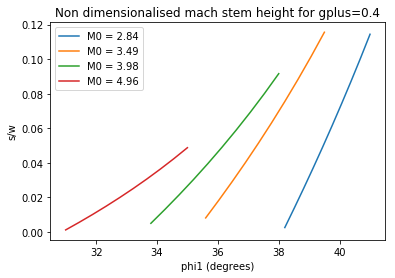

In [7]:
phi_1 = np.linspace(38.2,41,10)
s1 = [mounton(M=2.84,phi1 =i,gp=0.4) for i in phi_1]
phi2 = np.linspace(35.6,39.5,10)
s2 = [mounton(M=3.49,phi1 =i,gp=0.4) for i in phi2]
phi3 = np.linspace(33.8,38,10)
s3 = [mounton(M=3.98,phi1 =i,gp=0.4) for i in phi3]
phi4 = np.linspace(31.0,35,10)
s4 = [mounton(M=4.96,phi1 =i,gp=0.4) for i in phi4]
plt.plot(phi_1,s1,label='M0 = 2.84')
plt.plot(phi2,s2,label='M0 = 3.49')
plt.plot(phi3,s3,label='M0 = 3.98')
plt.plot(phi4,s4,label='M0 = 4.96')
plt.xlabel('phi1 (degrees)')
plt.ylabel('s/w')
plt.legend()
plt.title('Non dimensionalised mach stem height for gplus=0.4')
plt.savefig('MoutonMachStem.eps')
plt.show()

In [8]:
def mountonOE(M=3,phi1 = 38.5,p0t= 20, gamma=1.4):
    p1= (1+(gamma-1)*0.5*M**2)**(gamma/(gamma-1))
    phi1 = np.arcsin(np.sqrt(1+(p1/p0t-1)*(gamma+1)/gamma/2)/M)
    phi1=phi1*180/np.pi
    print("phi1 :", phi1)
    t1 = theta(phi1*np.pi/180,M) 
    s0=state(M=M,p=1, T = 300)
    s1,s2,s3=ST(s0,theta1=t1)
    print("Turn angle :", t1*180/np.pi)
    ae = ((1+(gamma-1)*0.5*M**2)*2/(gamma+1))**((gamma+1)/(2*(gamma-1)))*(1/M)
    print("ae :" ,ae)
    ###
    B = np.array([ae/2])
    B = np.append(B, ae/2)
    B = np.append(B,ae/2)
    B = np.append(B,0)
    B = np.append(B,mdot(s0)*ae/2)
    A = np.zeros([5,5])
    ###
    Ma = Mshock(np.pi/2,M,gamma = gamma, weak = 'True')
    Ar = ((1+(gamma-1)*0.5*Ma**2)*2/(gamma+1))**((gamma+1)/(2*(gamma-1)))*(1/Ma)
    #print("Area ratio :", Ar)
    phi = s2.phi-s1.theta
    delta = s1.theta-s2.theta
    A[0,0] = np.sin(s1.phi)
    A[0,1] = Ar
    A[1,1] = 1
    A[1,2] = np.sin(s1.theta)
    A[1,3] = np.sin(delta+np.arcsin(1/s2.M))
    A[2,1] = Ar
    A[2,2] = np.sin(s1.theta)
    A[2,4] = np.sin(phi)
    A[3,1] = -Ar+1
    A[3,3] = np.sin(delta+np.arcsin(1/s2.M))
    A[3,4] = -np.sin(phi)
    A[4,1] = mdot(s0)*Ar
    A[4,4] = np.sin(phi)*mdot(s1)
    #print(A)
    #print(B)
    x = np.linalg.solve(A,B)
    s = x[1]
    #print(x)
    return s*2**Ar


def mdot(state,gamma=1.4):
    pt = state.p*(1+(gamma-1)*0.5*state.M**2)**(gamma/(gamma-1))
    Tt = state.T*(1+(gamma-1)*0.5*state.M**2)
    mdot = state.M*(1+(gamma-1)*0.5*state.M**2)**(-gamma/2/(gamma-1))*(gamma/287/Tt)**0.5*pt
    return mdot

In [76]:
def moutonUE(M3=3,p0=200,gamma=1.4):
    M4 = np.sqrt((p0**((gamma-1)/gamma)-1)*2/(gamma-1))
    delta1 = nu(M4)-nu(M3)
    nu5 = nu(M4)+delta1
    M5 = Mpr(nu5)
    print("M4 :" , M4)
    print("M5 :" , M5)
    print("delta1 :", delta1*180/np.pi)
    print("mu0 :", np.arcsin(1/M3)*180/np.pi)
    print("mu1 :", np.arcsin(1/M4)*180/np.pi)
    p5=p0/((1+(gamma-1)*0.5*M5**2)**(gamma/(gamma-1)))
    H = ((1+(gamma-1)*0.5*M3**2)*2/(gamma+1))**((gamma+1)/(2*(gamma-1)))*(1/M3)
    H_ = ((1+(gamma-1)*0.5*M5**2)*2/(gamma+1))**((gamma+1)/(2*(gamma-1)))*(1/M5)
    s1 = H*np.cos(np.arcsin(1/M3))/np.sin(-delta1+np.arcsin(1/M3))
    s2 = H*np.cos(np.arcsin(1/M4)-delta1)/np.sin(-2*delta1+np.arcsin(1/M4))
    ae_ =  H+s1*np.sin(delta1)-(s2-s1)*np.sin(np.arcsin(1/M4)-2*delta1)/np.sin(np.arcsin(1/M4)-np.arcsin(1/M3)-3*delta1)/M4
    #print(delta1*180/np.pi)
    #print((nu5-delta1)*180/np.pi)
    print("s1 :", s1)
    print("s2 :", s2)
    print("ae_ :", ae_)
    print("H_ :",H_)
    s_ = mountonOE(M=M5,p0t =p0)
    print("s_ :", s_ )
    return s_*ae_/H_
    #return (delta1)*180/np.pi

In [253]:
def phiJet(p0t =3):
    M=3
    gamma=1.4
    #p0t = 20
    p1= (1+(gamma-1)*0.5*M**2)**(gamma/(gamma-1))
    phi1 = np.arcsin(np.sqrt(1+(p1/p0t-1)*(gamma+1)/gamma/2)/M)
    return phi1

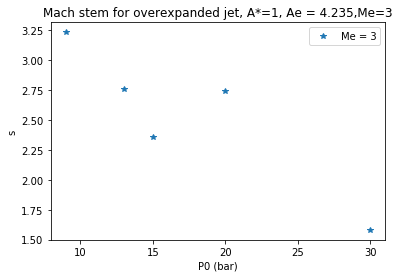

In [269]:
p0t = np.array([9,13,15,20, 30])
s = np.array([3.2334782667457045,2.7630384560614396, 2.3606529329143573,2.73983770924758,1.5806982437039825])
plt.plot(p0t,s,'*',label='Me = 3')
plt.xlabel('P0 (bar)')
plt.ylabel('s')
plt.legend()
plt.title('Mach stem for overexpanded jet, A*=1, Ae = 4.235,Me=3')
plt.savefig('MoutonJetMachStem.eps')
plt.show()

phi1 : 41.43098436607079
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
Theta max : [34.07343977]
Optimization terminated successfully.
         Current function value: -0.346207
         Iterations: 20
         Function evaluations: 40
Max shock angle for RR: [64.90985146 64.91035258]
This case is a Mach reflection
Solving for the Standard solution using 3 shock theory...
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
ThetaMax: [34.07343977]
Optimization terminated successfully.
         Current function value: -0.346207
         Iterations: 20
         Function evaluations: 40
ThetaMax: [19.83617903]


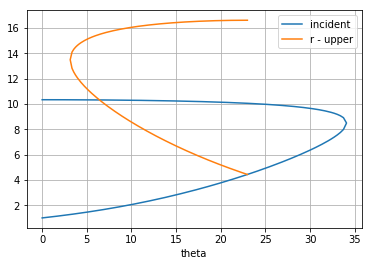

Output :  [28.07219465 87.73137397 16.56129832  6.41437101]
16.5612983243631
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
Theta max : [34.07343977]
Optimization terminated successfully.
         Current function value: -0.346207
         Iterations: 20
         Function evaluations: 40
Theta max : [19.83617903]
Turn angle : 22.97566933851734
ae : 4.23456790123457


2.023105667436989

In [89]:
mountonOE(M=3,phi1 = 38.5,p0t= 8.29, gamma=1.4)

In [90]:
2.023/4.23

0.47825059101654843

In [93]:
0.6781*4.234567

2.8714598827000004